# EDA To Prediction (DieTanic)

- source: <https://www.kaggle.com/ash316/eda-to-prediction-dietanic>

Part 1: Exploratory Data Analysis (EDA)
- Analysis of the features
- Finding any relations of trends considering multiple features

Part 2: Feature Engineering and Data Cleaning
- Adding any few features
- Removing redundant features
- Converting features into suitable form for modeling

Part 3: Predictive Modeling
- Running Basic Algorithms
- Cross Validation
- Ensembling
- Important Features Extraction

In [1]:
import zipfile
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV

# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
sns.set(font_scale=1.5)
%matplotlib inline

# Part 1: Exploratory Data Analysis (EDA)

## data check

### data load

In [3]:
with zipfile.ZipFile("titanic.zip", "r") as zipf:
    with zipf.open("train.csv") as f:
        data = pd.read_csv(f)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age, Cabin, Embarked는 실제로 NaN 값이 존재

### How many Survived

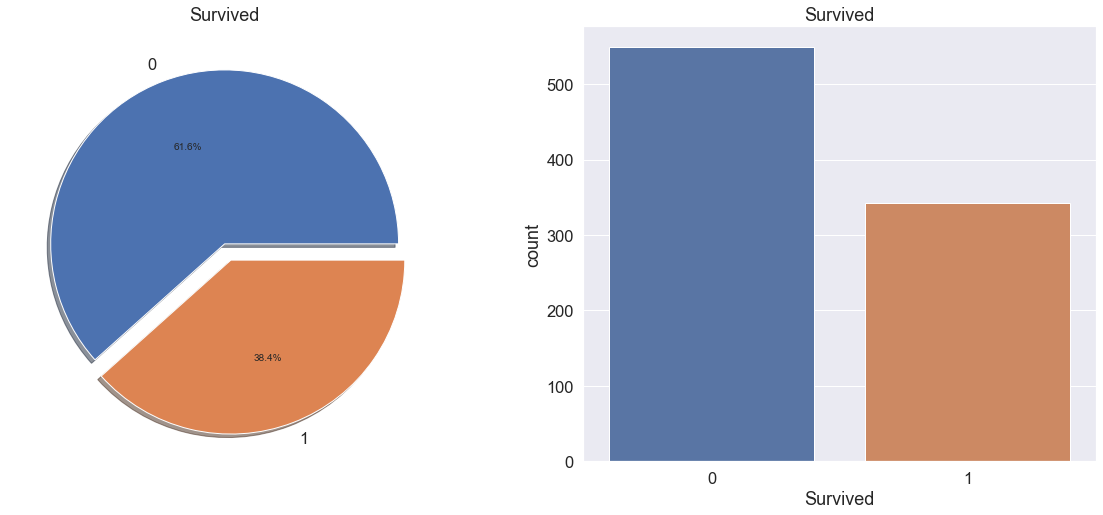

In [6]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data.Survived.value_counts().plot.pie(explode=(0, 0.1), autopct="%1.1f%%", ax=ax[0], shadow=True)
sns.countplot("Survived", data=data, ax=ax[1])

ax[0].set_ylabel("")
for i in range(2):
    ax[i].set_title("Survived")

plt.show()

### Types of Features

- Categorical Variable: Sex, Embarked
- Ordinal Variable: Pclass
- Countinuous Variable: Age

## Analysing The Features

### Sex -> Categorical Feature

In [7]:
data.groupby(["Sex", "Survived"])["Survived"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

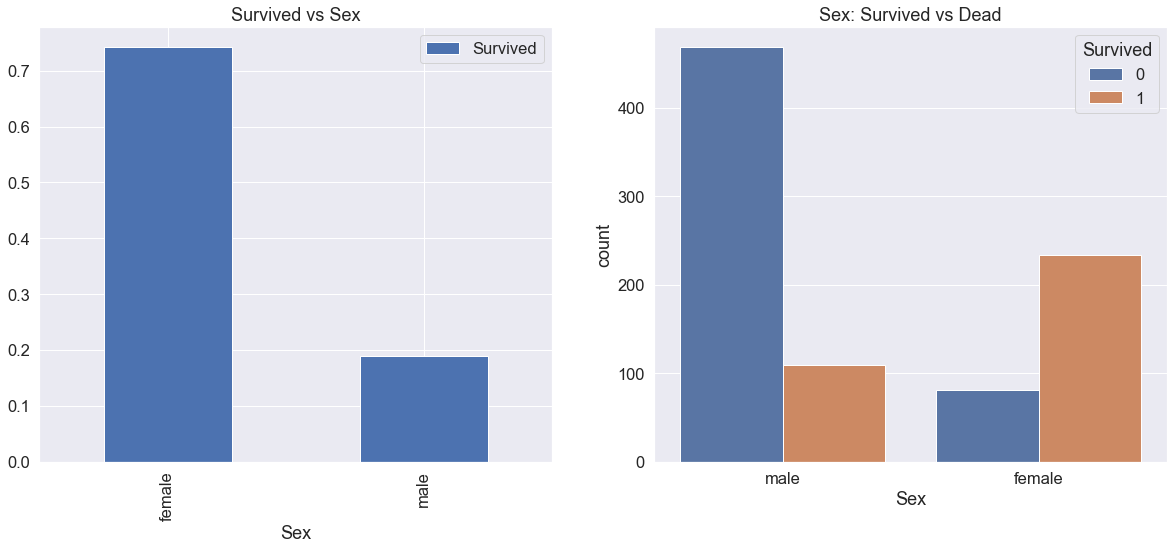

In [8]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data[["Sex", "Survived"]].groupby(["Sex"]).mean().plot.bar(ax=ax[0])
sns.countplot("Sex", hue="Survived", data=data)

ax[0].set_title("Survived vs Sex")
ax[1].set_title("Sex: Survived vs Dead")

plt.show()

여성의 생존율이 남성보다 높은 편이다. 이는 성별에 따른 count 생존율, 사망율을 보면 더 확실하게 알 수 있다.

### Pclass -> Ordinal Feature

In [9]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap="summer_r")

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Pclass별 생존율. 1 클래스의 생존율이 높으며, 3 클래스의 사망율이 높다.

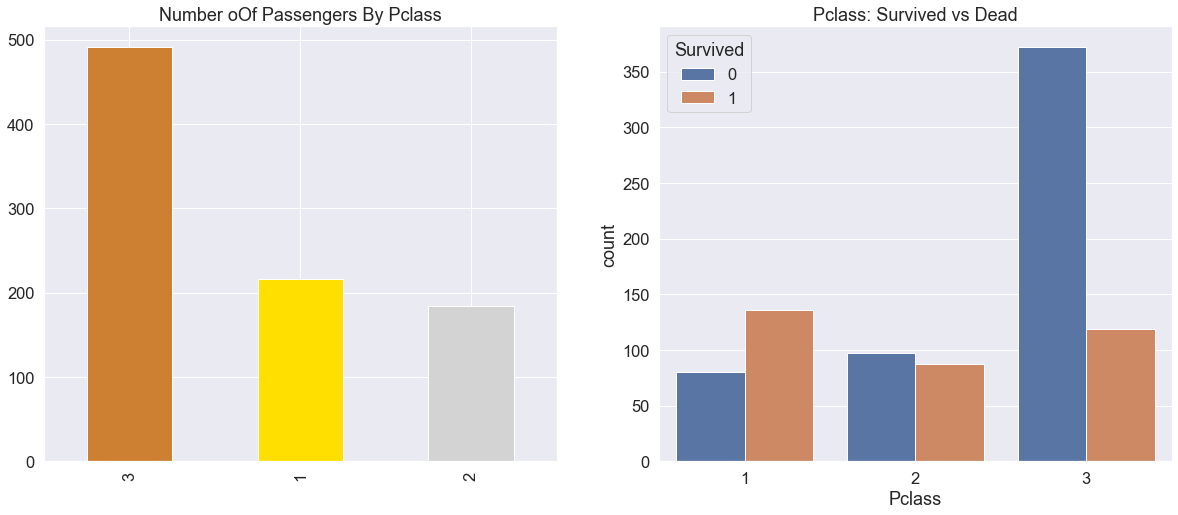

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data.Pclass.value_counts().plot.bar(color=["#CD7F32", "#FFDF00", "#D3D3D3"], ax=ax[0])
sns.countplot("Pclass", hue="Survived", data=data)

ax[0].set_title("Number oOf Passengers By Pclass")
ax[1].set_title("Pclass: Survived vs Dead")

plt.show()

3 class에 사람이 많았다. 그러나 생존율은 낮았지. 전체 생존율이 낮았으니 어쩌면 사람이 많은 것에 대한 반동일 수도.<br />
라고 생각하고 싶었지만, Pclass별 생존율의 차이가 있는 듯하다. class의 숫자가 작을수록 생존율은 높았다.<br />
되도록이면 알고 싶지 않았지만, Pclass는 정말 등급이었나보다. 이 물질만능주의 사회 같으니라고.

In [11]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap="summer_r")

초록색일수록 값이 크다. Pclass와 Pclass의 숫자는 비례한다. 남성일수록 기울기의 값이 크다.

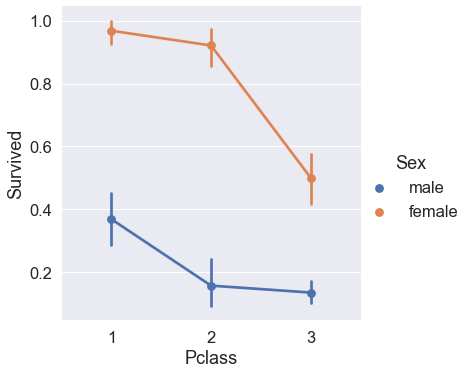

In [12]:
sns.factorplot("Pclass", "Survived", hue="Sex", data=data)
plt.show()

Pclass별 여성의 생존율은 남성의 2배 이상을 웃돌기도 한다.<br />
게다가 1 class의 여성은 생존율이 굉장히 높다. 신기한 건 1 class의 남성보다 2 class, 3 class의 여성의 생존율이 더 높다는 점이다. 완벽한 물질만능주의 사회는 아닌가 보다.

### Age -> Continuous Feature

In [13]:
print(f"가장 나이가 많아요: {data.Age.max()} years",
      f"가장 나이가 어려요: {data.Age.min()} years",
      "평균 나이는 이래요: {:.2f}".format(data.Age.mean()), sep="\n")

가장 나이가 많아요: 80.0 years
가장 나이가 어려요: 0.42 years
평균 나이는 이래요: 29.70


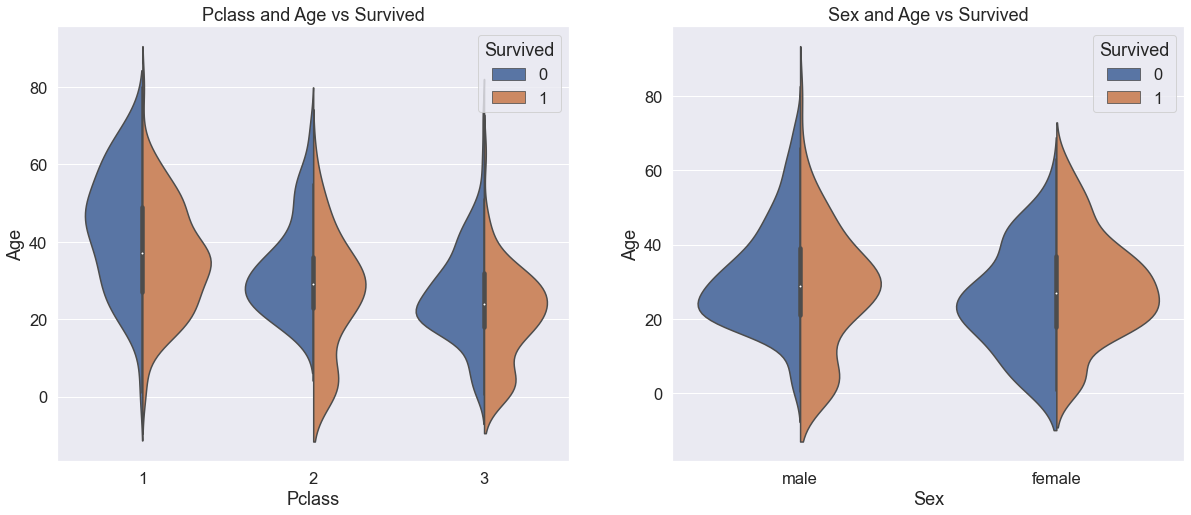

In [14]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True)
# split: hue로 나눠진 그림의 단면을 붙인다.

ax[0].set_title("Pclass and Age vs Survived")
ax[1].set_title("Sex and Age vs Survived")

plt.show()

x와 y에 대한 확률분포까지 확인할 수 있다지만, 확실히 난 violinplot이 눈에 잘 들어오는 것 같진 않다.

- Pclass의 숫자가 작을수록 대체로 나이가 많다.
- Pclass의 숫자가 클수록 나이가 어려지는 경향이 있다.
- 생존율에 대한 분포의 위치는 모든 class가 비슷하다.
- 2 class에서 생존율에 대한 나이 분포가 가장 넒은 range를 가지지만, 1 class의 분포가 많이 뚱뚱한 걸 보면 2 class가 나이에 상관없이 고루 생존율이 높다고 얘기하긴 어렵다고 본다.
- 남성, 여성 모두 (현재 시점의) 사회 초년생 ~ 사회인의 사망율(쉽게 말해 그림에서 20 ~ 40의 사망율)이 높다. 가장 많이 타고 있었다고 생각되는 나이대라서 그런 듯하다.

#### "What's In A Name??" ----> Feature :p

In [15]:
data.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [16]:
data["Initial"] = data.Name.str.extract("([A-Za-z]+)\.")

In [17]:
pd.crosstab(data.Sex, data.Initial).style.background_gradient(cmap="summer_r")

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [18]:
data["Initial"].replace([
    "Mlle", "Mme", "Ms", "Dr", "Major", "Lady", "Countess",
    "Jonkheer", "Col", "Rev", "Capt", "Sir", "Don"], [
    "Miss", "Miss", "Miss", "Mr", "Mr", "Mrs", "Mrs",
    "Other", "Other", "Other", "Mr", "Mr", "Mr"], inplace=True)

In [19]:
data.groupby("Initial")["Age"].agg(["count", "mean"])

,count,mean
Initial,,
Master,36,4.574167
Miss,150,21.860000
Mr,409,32.739609
Mrs,110,35.981818
Other,9,45.888889


#### Filling NaN Ages

In [20]:
for i in ["Mr", "Mrs", "Master", "Miss", "Other"]:
    data.loc[data.Age.isnull() & (data.Initial == i), "Age"] = int(round(data.loc[data.Initial == i, "Age"].mean(), 0))

In [21]:
data.Age.isnull().any()

False

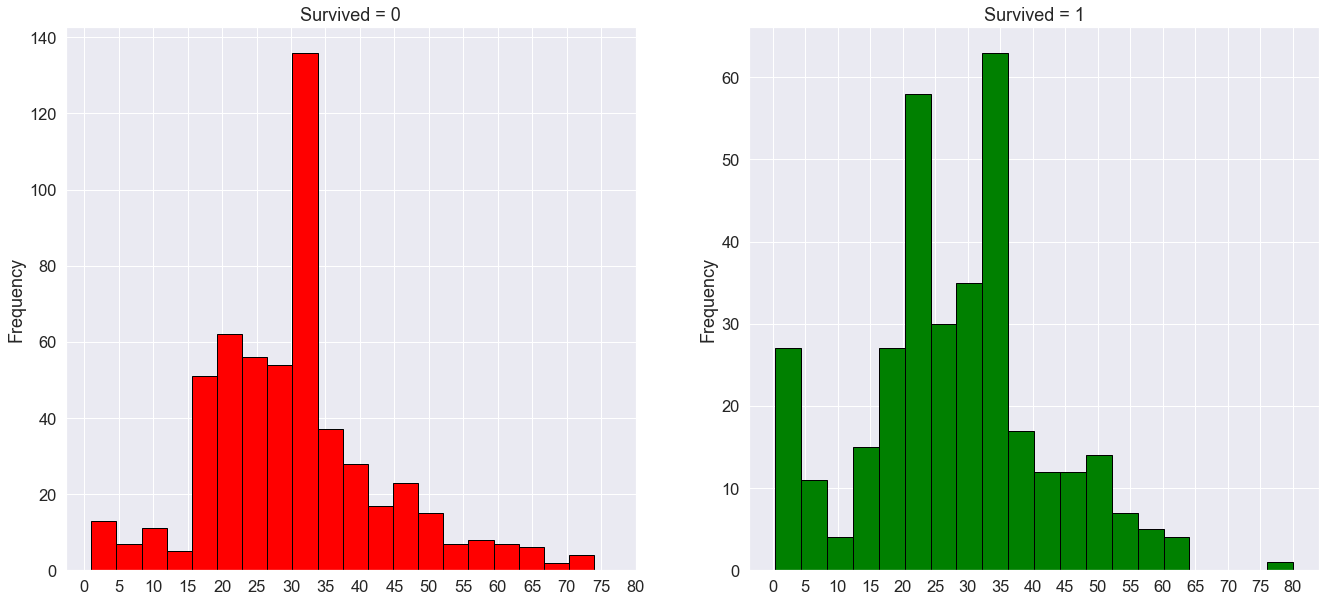

In [22]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

data[data.Survived == 0].Age.plot.hist(bins=20, color="red", edgecolor="black", ax=ax[0])
data[data.Survived == 1].Age.plot.hist(bins=20, color="green", edgecolor="black")

ax[0].set_xticks(list(range(0, 85, 5)))
ax[1].set_xticks(list(range(0, 85, 5)))
ax[0].set_title("Survived = 0")
ax[1].set_title("Survived = 1")

plt.show()

- 죽은 사람의 나이 최빈값이나 산 사람의 나이 최빈값이나 비슷하다?
- 죽은 사람의 분포는 첨도가 큰 분포라면, 산 사람의 분포는 왼쪽 꼬리가 두꺼운 분포이다. 즉, 골고루 살았다?
- 상당히 10세 미만의 어린이가 많다. 가족끼리 탑승한 경우가 많았나보다.

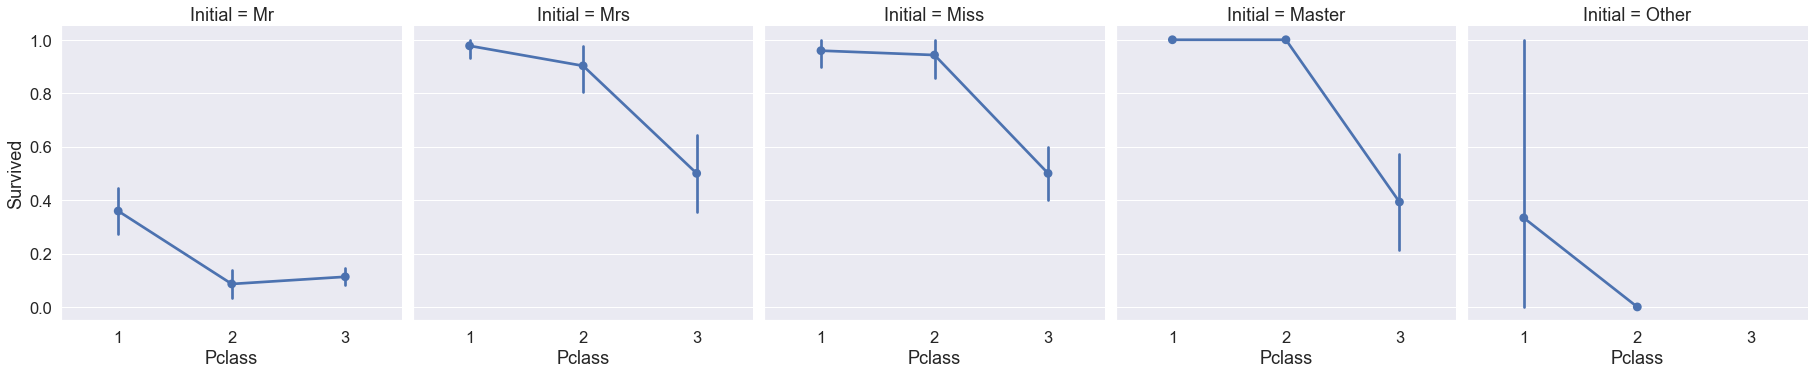

In [23]:
sns.factorplot("Pclass", "Survived", col="Initial", data=data) # row="Initial"
plt.show()

- 어린 아이를 지칭하는 것으로 보였던 Other는 class의 숫자가 작은 쪽에 몰려있다. 어린아이들은 대체로 살았다는 얘기가 되어 다행이다.
- 모든 Initial에 대하여 Pclass의 숫자가 클수록 생존율이 낮아진다. 물질만능주의..

### Embarked -> Categorical Value

In [24]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient(cmap="summer_r")

- 확실히 여성의 생존율이 높다.
- 근데 Q 항구를 통한 3 class 여성 탑승객의 생존율이 다른 항구에 비해 높은 것으로 보인다?
- Q 항구의 탑승객의 객실 위치가 초기 침몰 지점의 반대쪽이거나 구출 지점에 가까운 건가?

#### Chances for Survival by Port Of Embarkation

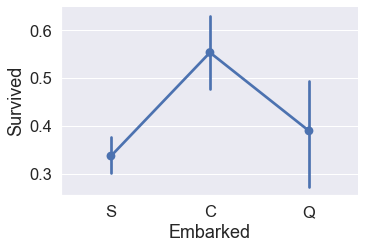

In [25]:
sns.factorplot("Embarked", "Survived", data=data)
plt.gcf().set_size_inches(5, 3) # plt.figure(figsize)로 조절하려고 했으나 안 됐음.
plt.show()

C 항구에 대한 생존율이 높다.

- 항구와 성별 or 항구와 Pclass 간의 관계가 있다고 보여진다.

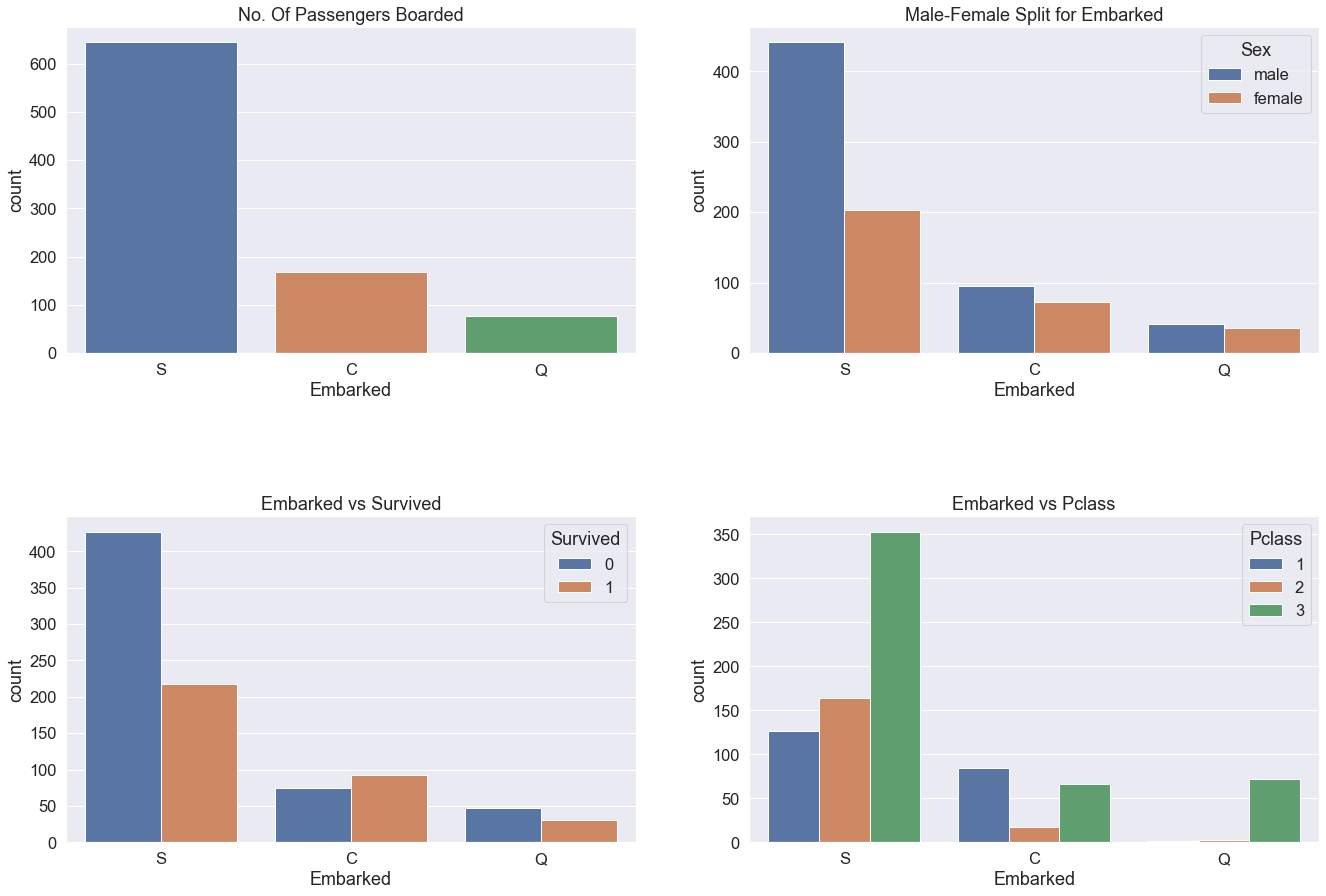

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot("Embarked", data=data, ax=ax[0, 0])
sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
sns.countplot("Embarked", hue="Pclass", data=data)

ax[0, 0].set_title("No. Of Passengers Boarded")
ax[0, 1].set_title("Male-Female Split for Embarked")
ax[1, 0].set_title("Embarked vs Survived")
ax[1, 1].set_title("Embarked vs Pclass")

plt.subplots_adjust(wspace=.2, hspace=.5)
plt.show()

- S 항구를 통해 탑승한 사람이 제일 많다. (S > C > Q)
- 그래서 사망율 또한 높다.
- Embarked와 Sex는 큰 관련이 없다. 그냥 S 항구에서 탄 사람 중에 남성의 비율이 높을 뿐.
- S 항구는 그냥 대중적인 항구인가 보다. 여러 사람이 많이 탔네.
- C 항구의 생존율이 사망율보다 높다. 1 class의 사람이 많았거나, 여성이 많았거나.

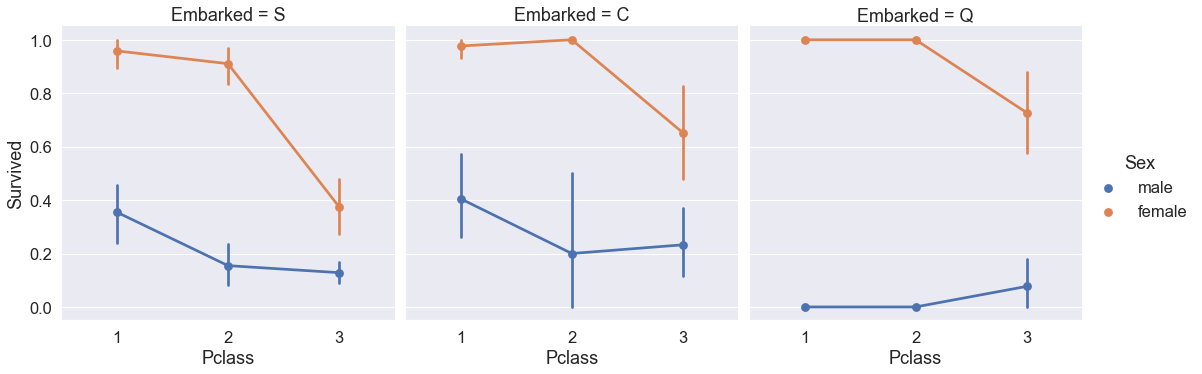

In [27]:
sns.factorplot("Pclass", "Survived", hue="Sex", col="Embarked", data=data)
plt.show()

- 모든 항구에 대해서 Pclass의 숫자가 작을수록 생존율이 높다.
- 모든 항구에 대해서 여성의 생존율은 3 class만 아니면 상당히 높다.
- 간만에 3 class에 대한 생존율이 높은가 했더니 Q 항구에선 극소수 말고는 3 class의 사람만 탔으니, 생존율이 높게 나올 수밖에.

#### Filling Embarked NaN

In [28]:
data["Embarked"].fillna("S", inplace=True)

In [29]:
data.Embarked.isnull().any()

False

### SibSp -> Discrete Feature

In [30]:
pd.crosstab(data.SibSp, data.Survived).style.background_gradient(cmap="summer_r")

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


남매가 없을수록 생존율 향상의 도움이 된다. 아마 서로 챙기느라 제때 탈출하지 못한 것으로 보인다.

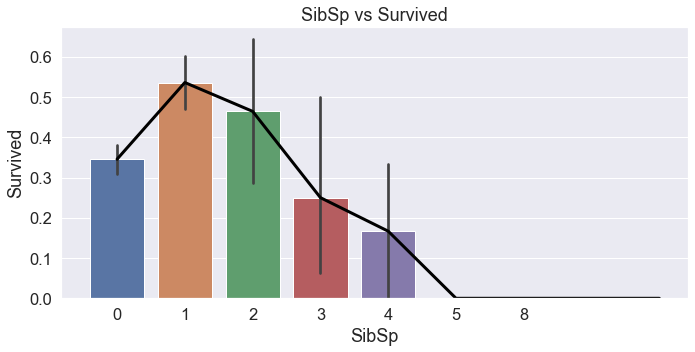

In [31]:
plt.figure(figsize=(10, 5))

sns.barplot("SibSp", "Survived", data=data)
plt.plot(data[["SibSp", "Survived"]].groupby("SibSp")["Survived"].mean(),
         c="black", linewidth=3)
# sns.factorplot("SibSp", "Survived", data=data)

plt.title("SibSp vs Survived")
plt.show()

seaborn은 graph type별로 차지하는 figure에 차이가 있어보인다. 그래서 sns.barplot과 sns.factorplot가 matplotlib를 통해 나눈 figure에 들어가지 않는다. 그래서 이렇게 표현해봤다. plot의 선이 좀 얇긴 하지만, 만족스럽다.

- 최대 생존의 기회만 따지면 남매가 2 정도일 때 생존율이 가장 높다. 그러나 평균적인 (평균뿐만 아니라 다른 대푯값들을까지 생각했을 때) 생존율은 남매가 하나일 때 가장 높다.
- 신기한 건 (남매 수에 대한 확률까진 생각해보지 않았지만 대략적으로) 일단 남매로 탑승한 승객의 생존율이 높다.

In [32]:
# 가설: Survival rate (SibSp = 0) < Survival rate (SibSp > 0)
# 여러 시도 끝에 모비율 검정을 하기로 했는데, survived의 case가 전체 생존 or 일부 생존임을 알 수 없어 숫자로 대입할 수 없고, 따라서 순서 case로 생각하여 통합 후 계산

from statsmodels.stats.proportion import proportions_ztest

temp = data[["SibSp", "Survived"]].groupby("SibSp")["Survived"].agg(["count", "sum", "mean"])
print(proportions_ztest(count=[temp["sum"][0], temp["sum"][1:].sum()],
                        nobs=[temp["count"][0], temp["count"][1:].sum()], value=0))
del temp

(-3.4586011649424178, 0.0005429883114693003)


명 수까지 확인해서 얼마만큼 다르다고 말할 순 없지만, 범주로 따졌을 때 형제 없이 탑승했을 때 생존율과 형제가 같이 탑승했을 때의 생존율에는 차이가 있다.

In [33]:
pd.crosstab(data.SibSp, data.Pclass).style.background_gradient(cmap="summer_r")

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


- 남매가 없는 사람이 많았는데, 그건 Pclass의 숫자가 클 때 더 많았다.
- SibSp의 분포에 3 class 사람이 골고루 많다. 3 class만 생각하면 SibSp와 Pclass 간의 관계가 있다고 여겨질만큼.

### Parch

In [34]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient(cmap="summer_r")

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


아, Parch가 Parents, Children이었던가. 여하튼 3 class의 가족 단위가 큰 경우가 많다. 이게 SibSp의 크기가 꽤 커졌을 때 생존율이 바닥을 친 이유라고 생각된다.

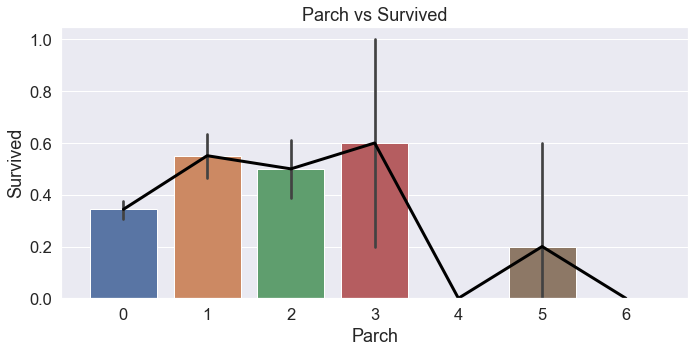

In [35]:

# plt.plot(data[["SibSp", "Survived"]].groupby("SibSp")["Survived"].mean(), c="black")
# sns.factorplot("SibSp", "Survived", data=data)
plt.figure(figsize=(10, 5))

sns.barplot("Parch", "Survived", data=data)
plt.plot(data[["Parch", "Survived"]].groupby("Parch")["Survived"].mean(),
         c="black", linewidth=3)

plt.title("Parch vs Survived")
plt.show()

- 의외인 게, Parch는 SibSp에 비해 range가 작다.
- 그리고 Parch가 적당히 있을 때 생존율이 높았다.
- 아마 셋 이상부터는 생존이 거의 운이었는 듯하다. 3, 5일 때에 속하는 사람이 많지만, 사람이 많아서 많이 살았다고 하기엔, 4에는 1 class도 있다.

### Fare -> Continuous Feature

In [36]:
print(f"제일 비쌌어요: {data.Fare.max():.2f}",
      f"제일 쌌을걸요: {data.Fare.min():.2f}",
      f"평균은 이래요: {data.Fare.mean():.2f}", sep="\n")

제일 비쌌어요: 512.33
제일 쌌을걸요: 0.00
평균은 이래요: 32.20


이벤트에 당첨되거나 (윤리적으로) 너무 어린 손님이라 값을 청구하기 어려웠나보다.

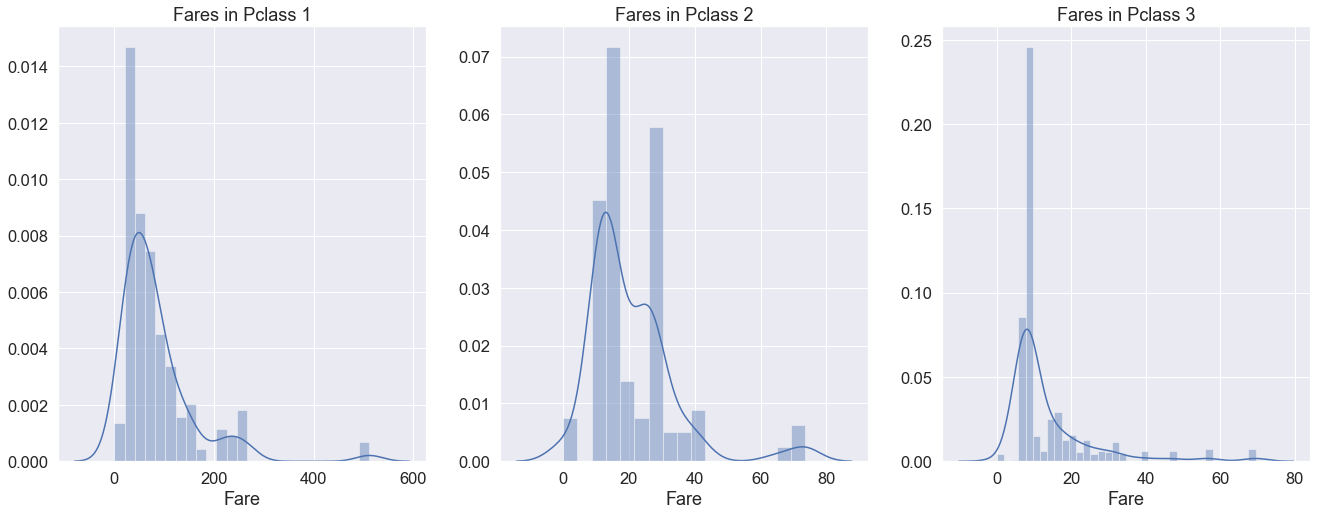

In [37]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.distplot(data[data.Pclass == 1].Fare, ax=ax[0])
sns.distplot(data[data.Pclass == 2].Fare, ax=ax[1])
sns.distplot(data[data.Pclass == 3].Fare)

for i in range(len(ax)):
    ax[i].set_ylabel("")
    ax[i].set_title("Fares in Pclass " + str(i + 1))

plt.show()

distplot이 그리는 선이 과대적합에서 벗어났나보다. 아니면 내가 range를 원본으로 해서 그렇게 보이는 걸 수도 있고.

- 확실히 1 class는 비싼 등급이구만. 단위가 달라.
- 첨도와 특이값이 심하긴 하지만, 1과 3 class는 Fare에 대한 정규분포를 이룬다고도 볼 수 있을 것 같다.

### Correlation Between The Features

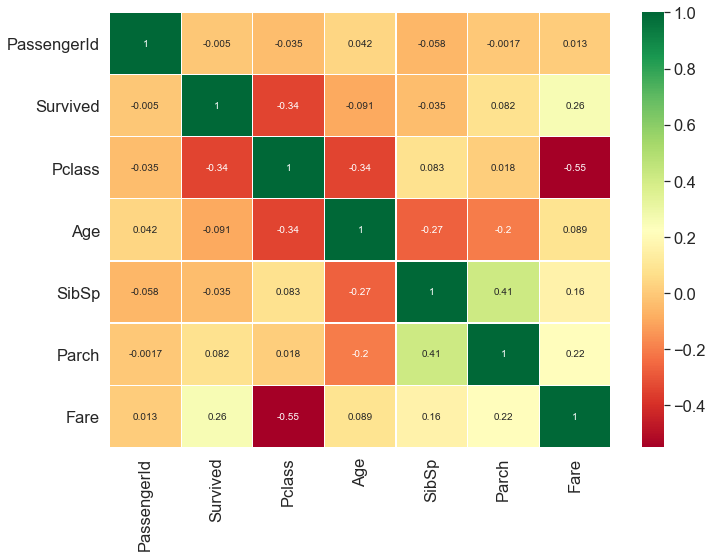

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=0.2)
# plt.gcf().set_size_inches(10, 8)
plt.show()

- Pclass 숫자가 작을수록 Fare가 높다거나 / Pclass 숫자가 작을수록 나이가 많다거나 / Pclass 숫자가 작을수록 생존율이 높다는 건 딱히 알고 싶지 않다.
- 나이가 어릴수록 남매가 있는 경우가 많다.

# Part2: Feature Engineering and Data Cleaning

## Age_band

In [39]:
data["Age_band"] = 0
for i in range(4):
    data.loc[(data.Age > i * 16) & (data.Age <= 16 * (i + 1)), "Age_band"] = i
data.loc[(data.Age > 64), "Age_band"] = 4

In [40]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2


In [41]:
data.Age_band.value_counts().to_frame().style.background_gradient(cmap="summer_r")
# data[["PassengerId", "Age_band"]].groupby("Age_band")["PassengerId"].count().to_frame().style.background_gradient(cmap="summer_r")

,Age_band
1,382
2,325
0,104
3,69
4,11


처음 그룹에 대한 사람이 많다. 16 ~ 32, 32 ~ 48살인 사람이 많은 가보다.

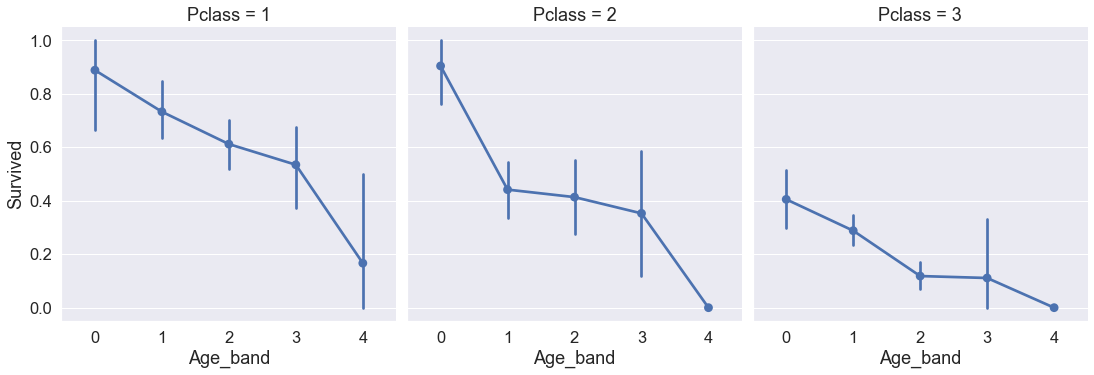

In [42]:
sns.factorplot("Age_band", "Survived", col="Pclass", data=data)
plt.show()

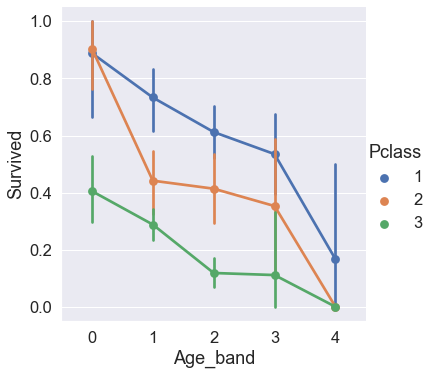

In [43]:
sns.factorplot("Age_band", "Survived", hue="Pclass", data=data)
plt.show()

분포가 왜 이따위인지 모르겠지만, 신기하게 생기긴 했다.

- Pclass에 상관없이 나이가 어릴수록 생존율이 높다. 다행이다.
- 생존율의 추이는 1 class와 2 class가 유사한 편이다.
- Age_band에 대한 생존율 분포가 가장 넓은 나이대는 Pclass별로 4, 3, 3이다.

## Family_Size and Alone

In [44]:
data["Family_Size"] = data["Parch"] + data["SibSp"]
data["Alone"] = 0
data.loc[data.Family_Size == 0, "Alone"] = 1

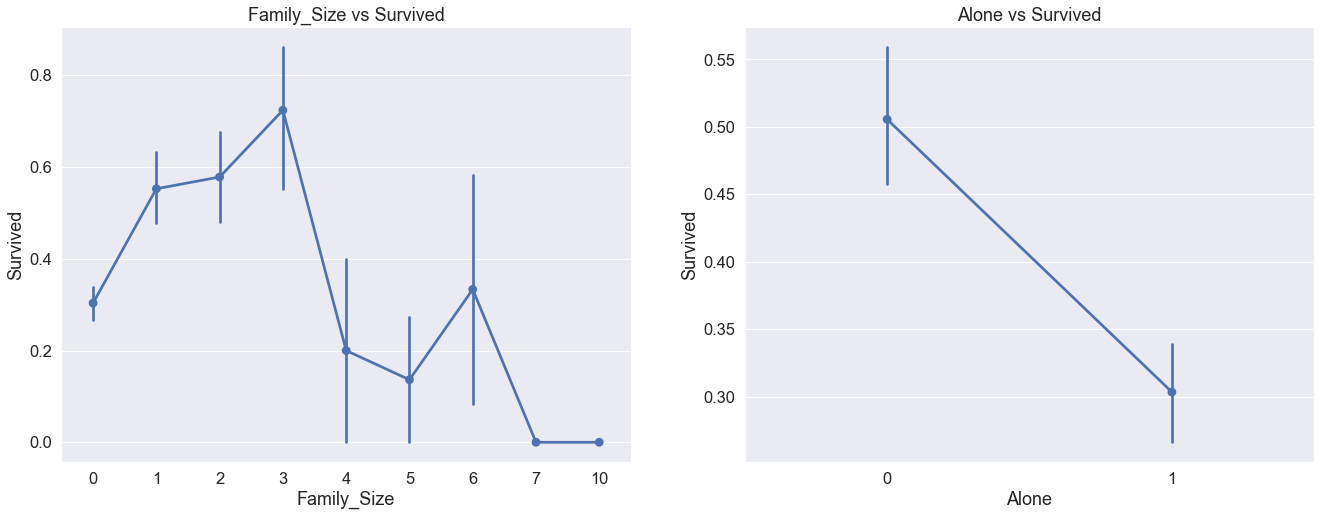

In [45]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

for idx, col in enumerate(["Family_Size", "Alone"]):
    sns.pointplot(col, "Survived", data=data, ax=ax[idx])
    # ax[idx].plot(data[[col, "Survived"]].groupby(col)["Survived"].mean())
    # ax[idx].set_xlabel(col)
    ax[idx].set_title(col + " vs Survived")

# plt.close(2)
# plt.close(3)
plt.show()

- 어째 혼자였을 때보다 가족 단위 탑승이었을 때의 생존율이 높다. 이게 티켓을 기준으로 하다 보니까 가족이 다 살아남았을 때 Survived인지, 하나라도 살아남았으면 Survived인지 헷갈린다. 하여간 이것만 보면 혼자 탑승한 경우의 생존율이 더 낮다. 혼자 탑승한 사람이 많았거나 다른 이들의 탈출을 도왔거나.
- 그러나 세부적으로 따지면 혼자 탑승했을 때의 생존율이 그리 적진 않은 편이다.

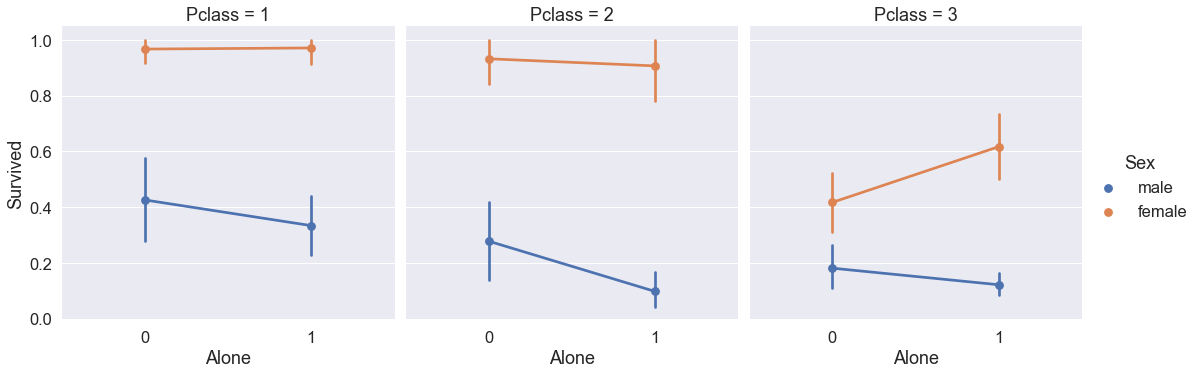

In [46]:
sns.factorplot("Alone", "Survived", hue="Sex", col="Pclass", data=data)
plt.show()

- 여성의 생존율은 상당히 높다.
- 특히 Pclass가 높다면(숫자가 작다면) 더더욱. (사실 3 class 말곤 크게 차이 나지 않는다)
- 신기하게도 3 class에서는 반전된다. 여성은 혼자였을 때 오히려 생존율이 높다. 이것도 매너인가.

## Fare_Range

In [47]:
data["Fare_Range"], bins = pd.qcut(data["Fare"], 4, retbins=True)
data.groupby(["Fare_Range"])["Survived"].mean().to_frame().style.background_gradient(cmap="summer_r")

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


엑셀에도 이런 함수가 있었지. 근데 대체로 bar plot 시각화 가능한 언어들에선 자동적으로 그 범주를 계산하는 방식을 사용자가 친숙하게 여기는 경우가 많아서 대체로 다 있을 걸?

In [48]:
data["Fare_cat"] = 0
for idx in range(1, len(bins) - 1):
    data.loc[(data["Fare"] > bins[idx]) & (data["Fare"] <= bins[idx + 1]) , "Fare_cat"] = idx

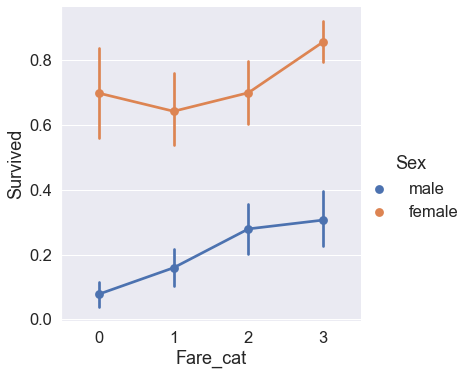

In [49]:
sns.factorplot("Fare_cat", "Survived", hue="Sex", data=data)
plt.show()

- 확실히 여성의 생존율이 높다.
- 여성의 생존율은 Fare_cat과 선형적으로 정비례한다고 보기 어렵다. 이차 관계랄까.
- 그에 반해 남성의 생존율은 Fare_cat과 더 선형적으로 관계가 있어보인다.

## Converting String Values into Numeric

In [50]:
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].replace(["S", "C", "Q"], [0, 1, 2], inplace=True)
data["Initial"].replace(["Mr", "Mrs", "Miss", "Master", "Other"], [0, 1, 2, 3, 4], inplace=True)

## Dropping UnNeeded Features

In [51]:
data.drop(["Name", "Age", "Ticket", "Fare", "Cabin", "Fare_Range", "PassengerId"], axis=1, inplace=True)

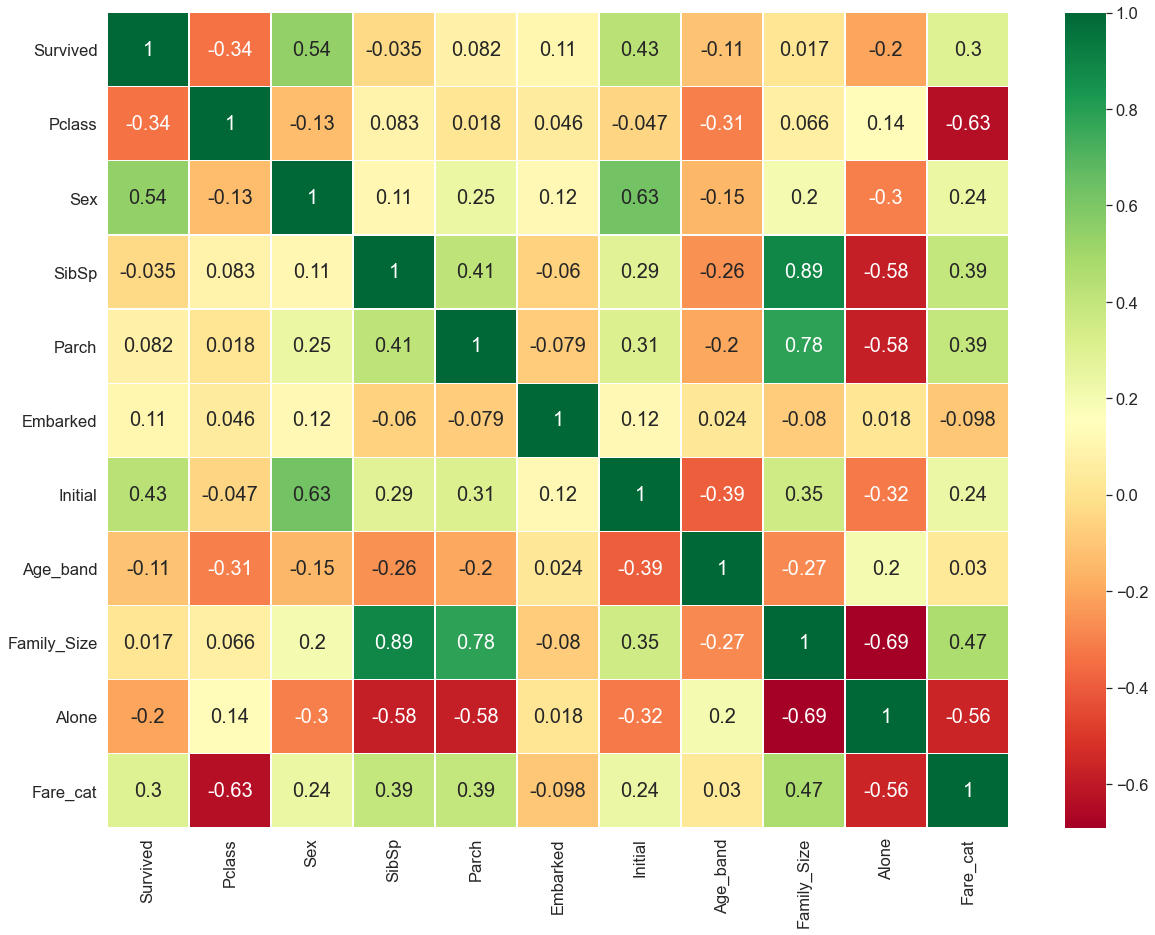

In [52]:
plt.figure(figsize=(18, 15))

sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=.2, annot_kws={"size": 20})

# plt.gcf().set_size_inches(18, 15)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()

- Pclass랑 Survived, 관계가 있는 편이라 슬픕니다.
- Sex랑 Survived, 지금가지 봐었던 것처럼 (여성이 1이므로) 양의 관계를 가짐.
- Initial이랑 Survived, Initial이 은근히 성별을 구분 짓는 시기라 Sex와 Initial 다중공선성 위험.

<details>
  <summary>Pclass 관련</summary>
  - Survived, Pclass<br />
  - Age_band랑 Pclass, 탑승객이 나이가 많으면 부자였다는 것. 이런 물질만능주의 사회.<br />
  - Fare_cat랑 Pclass, 이걸 위와 섞어서
<br /><br />
</details>

<details>
  <summary>Sex 관련</summary>
  - Survived, Sex<br />
  - Initial랑 Sex, 성별에 따른 (호칭류) 수식어가 다른 시기다. 이것을 통해 성별을 구분할 수 있을 정도. 그러나 현재 데이터에선 다중공선성이 심하게 나타나지 않았다.<br />
  - Alone이랑 Sex, 생각보다 여성일수록 혼자 탑승한 경우가 적었다. 선상 파티 같은 건 정말 아니었나 보다.
<br /><br />
</details>

<details>
  <summary>SibSp 관련</summary>
  - Survived랑 SibSp, -0.003.. 이 정도면 사실 딥러닝에서도 배제하는 변수 취급을 받아야 하는 거 아닐까.<br />
  - Parch랑 SibSp, 혈육이랑 같이 탔다면 부모도 같이 탔을 가능성이 높다. 그래서 그에 대한 선형 관계성이고. 이것 또한 다행히 다중공선성을 보이지 않는다.<br />
  - Family_size와 SibSp, 앞선 Parch보다 심각하다. 개념적으로도 Family_size는 SibSp와 선형관계를 가진다. 현재 데이터에선 그리 많이 나타난 것처럼 보이지 않지만, 개념적으로나 값으로나 상당히 다중공선성의 위험을 가진 변수 관계이다.<br />
  - Alone과 SibSp, 앞선 Parch나 Family_size처럼 색다른 관계가 아니다. 당연히 가족이랑 왔으면 혼자 온 것이 아니므로 Alone의 값이 0일 테니까.<br />
  - Fare_cat이랑 SibSp, 가족이 있으면 ticket 요금을 더 냈을 수도 있다. 결제나 탑승할 때 ticket을 보고 기록한 것이라면 당연하게도 Fare(Fare_cat)과 함께 탄 혈육의 수는 비례해야 한다.
<br /><br />
</details>

<details>
  <summary>Parch 관련</summary>
  - Survived과 Parch, Parch도 앞선 SibSp처럼 선형 관계가 있다고 얘기하긴 어렵다. 아무래도 같이 탑승한 사람이 많았다면 모두 살리고자 했을 것이다.<br />
  - SibSp, Parch<br />
  - Initial과 Parch, 아마 같이 탑승한 사람 중 부모는 한 사람 당 최대 2일 것이고, 이들의 성별이나 성은 대체로 유사할 것이라는 것은 꽤 일반적인 추론이다.<br />
  - Family_Size와 Parch, 당연히 부모의 수는 가족의 수에 들어가기 때문에 이 둘의 상관계수는 크다.<br />
  - Alone과 Parch, 앞서와 마찬가지로 부모와 함께 왔다면 혼자 온 것이 아니니 이 둘은 음의 상관관계를 가진다.<br />
  - Fare_cat과 Parch, 가족 단위로 왔다면 ticket 비용이 비쌌을 것이고, 이는 Fare_cat이 큰 값으로 측정되었을 것이다.
<br /><br />
</details>

<details>
  <summary>Embarked 관련</summary>
  - Survived과 Embarked, 의외로 꽤 관련이 없다. Embarked를 ordered 숫자로 치환한 게 문제일 수도 있다.
<br /><br />
</details>

<details>
  <summary>Initial 관련</summary>
  - Survived과 Initial, 앞서 말했던 것처럼 Initial은 생존율이 높은 여성과 아이를 구분할 수 있는 기준이 된다는 점에서 생존율과 관련이 있다.<br />
  - Sex, Initial<br />
  - Parch, Initial<br />
  - Age_band와 Initial, 생존율이 높은 아이를 구분할 수 있으므로 중요하다.<br />
  - Family_Size과 Initial, 가족 구성은 꽤 정해져 있다. 그런 점에서 성별이나 아이를 구분할 수 있는 Initial은 Family_Size와 관련이 있다.
<br /><br />
</details>

<details>
  <summary>Age_band 관련</summary>
  - Survived과 Age_band, 아이를 구분할 수 있음에도 그거 말고는 선형적으로 일관된 관계를 찾을 수 있지 않으니 관계성이 적은 듯하다.<br />
  - Pclass, Age_band<br />
  - Initial, Age_band
<br /><br />
</details>

<details>
  <summary>Family_Size 관련</summary>
  - Survived과 Family_Size, 선형적으로 함께 탑승한 가족의 수가 많으면 생존율이 낮았다.<br />
  - SibSp, Family_Size<br />
  - Parch, Family_Size<br />
  - Initial, Family_Size<br />
  - Alone과 Family_Size, 당연히 혼자 왔다면 가족이랑 오지 않은 것이고, 가족이랑 왔다면 혼자 온 것이 아니다.<br />
  - Fare_cat과 Family_Size, 같이 탑승한 가족의 수가 많다면 사람 수에 따른 요금을 냈을 것이다. 따라서 둘은 선형적인 관련이 있다.
<br /><br />
</details>

<details>
  <summary>Alone 관련</summary>
  - Survived과 Alone, 혼자 있을 때의 생존율이 낮았을 때를 생각하면 더 높을 줄 알았는데, 이 정도로 선형 관계성이 적다니.<br />
  - Sex, Alone<br />
  - SibSp, Alone<br />
  - Parch, Alone<br />
  - Initial, Alone<br />
  - Family_Size, Alone<br />
  - Fare_cat과 Alone, 데이터가 정말 ticket 결제였던 건가? 그래서 혼자 타서 Fare_cat이 적은 건가?
<br /><br />
</details>

<details>
  <summary>Fare_cat 관련</summary>
  - Survived과 Fare_cat, 비싼 Pclass을 산 승객의 생존율이 높았다. Pclass는 Fare_cat과 관련이 있고, 또 Survived와도 관련이 있다. 그래서 슬프게도 돈을 많이 지불할수록 생존에 영향을 미쳤다.<br />
  - Pclass, Fare_cat<br />
  - SibSp, Fare_cat<br />
  - Parch, Fare_cat<br />
  - Family_Size, Fare_cat<br />
  - Alone, Fare_cat
<br /><br />
</details>

# Part3: Predictive Modeling

1. Logistic Regression
2. Support Vector Machine
3. Naive Bayes
4. K-Nearest Neighbors
5. Decision Tree
6. Random Forest

### data

In [53]:
train, test = train_test_split(data, test_size=0.3, random_state=0, stratify=data.Survived)

train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]

test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]

X = data[data.columns[1:]]
Y = data.Survived

## LR: Logistic Regression

In [54]:
model = LogisticRegression()
model.fit(train_X, train_Y)

LogisticRegression()

In [55]:
pred1 = model.predict(test_X)
print("Accuracy for LR is", accuracy_score(pred1, test_Y))

Accuracy for LR is 0.8134328358208955


## SVM: Support Vector Machine

### linear-SVM

In [56]:
model = SVC(kernel="linear", C=.1, gamma=.1)
model.fit(train_X, train_Y)

SVC(C=0.1, gamma=0.1, kernel='linear')

In [57]:
pred21 = model.predict(test_X)
print("Accuracy for linear SVM is", accuracy_score(pred21, test_Y))

Accuracy for linear SVM is 0.8171641791044776


### rbf-SVM

In [58]:
model = SVC(kernel="rbf", C=1, gamma=.1)
model.fit(train_X, train_Y)

SVC(C=1, gamma=0.1)

In [59]:
pred22 = model.predict(test_X)
print("Accuracy for rbf SVM is", accuracy_score(pred22, test_Y))

Accuracy for rbf SVM is 0.835820895522388


## Naive Bayes

In [60]:
model = GaussianNB()
model.fit(train_X, train_Y)

GaussianNB()

In [61]:
pred3 = model.predict(test_X)
print("Accuracy for Naive Bayes is", accuracy_score(pred3, test_Y))

Accuracy for Naive Bayes is 0.8097014925373134


## KNN: K-Nearest Neighbors

In [62]:
model = KNeighborsClassifier()
model.fit(train_X, train_Y)

KNeighborsClassifier()

In [63]:
pred4 = model.predict(test_X)
print("Accuracy for KNN is", accuracy_score(pred4, test_Y))

Accuracy for KNN is 0.8246268656716418


n_neighbors의 default는 5이다.

In [64]:
knn_scores = []
for i in list(range(1, 11)):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X, train_Y)

    prediction = model.predict(test_X)
    knn_scores.append(accuracy_score(prediction, test_Y))

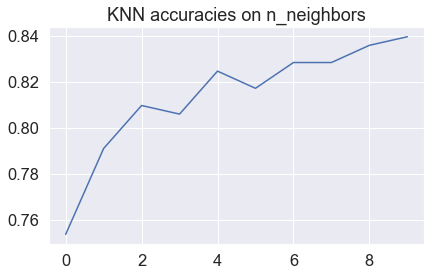

In [65]:
length = np.arange(len(knn_scores))
plt.plot(length, knn_scores)
# plt.gcf().set_size_inches(12, 6)
plt.title("KNN accuracies on n_neighbors")
plt.show()

In [66]:
np.max(knn_scores)

0.8395522388059702

## Tree

### DT: Decision Tree

In [67]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)

DecisionTreeClassifier()

In [68]:
pred5 = model.predict(test_X)
print("Accuracy for DT is", accuracy_score(pred5, test_Y))

Accuracy for DT is 0.7985074626865671


### RF: Random Forest

In [69]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_Y)

RandomForestClassifier()

In [70]:
pred6 = model.predict(test_X)
print("Accuracy for RF is", accuracy_score(pred6, test_Y))

Accuracy for RF is 0.8208955223880597


## Cross Validation

In [71]:
classifiers = ["LR", "Linear SVM", "Radial SVM", "Naive Bayes", "KNN", "DT", "RF"]
models = [LogisticRegression(), SVC(kernel="linear"), SVC(kernel="rbf"), GaussianNB(), KNeighborsClassifier(n_neighbors=9), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]

In [72]:
kfold = KFold(n_splits=10, shuffle=True, random_state=22)
accuracies = []
xyz, std = [], []

for model in models:
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
    accuracies.append(cv_result)
    xyz.append(cv_result.mean())
    std.append(cv_result.std())

cv_df = pd.DataFrame({"Mean": xyz, "Std": std}, index=classifiers)
del xyz, std

In [73]:
cv_df

,Mean,Std
LR,0.801423,0.039375
Linear SVM,0.783483,0.058336
Radial SVM,0.828377,0.057096
Naive Bayes,0.794719,0.055611
KNN,0.809251,0.039595
DT,0.802497,0.046514
RF,0.813733,0.046994


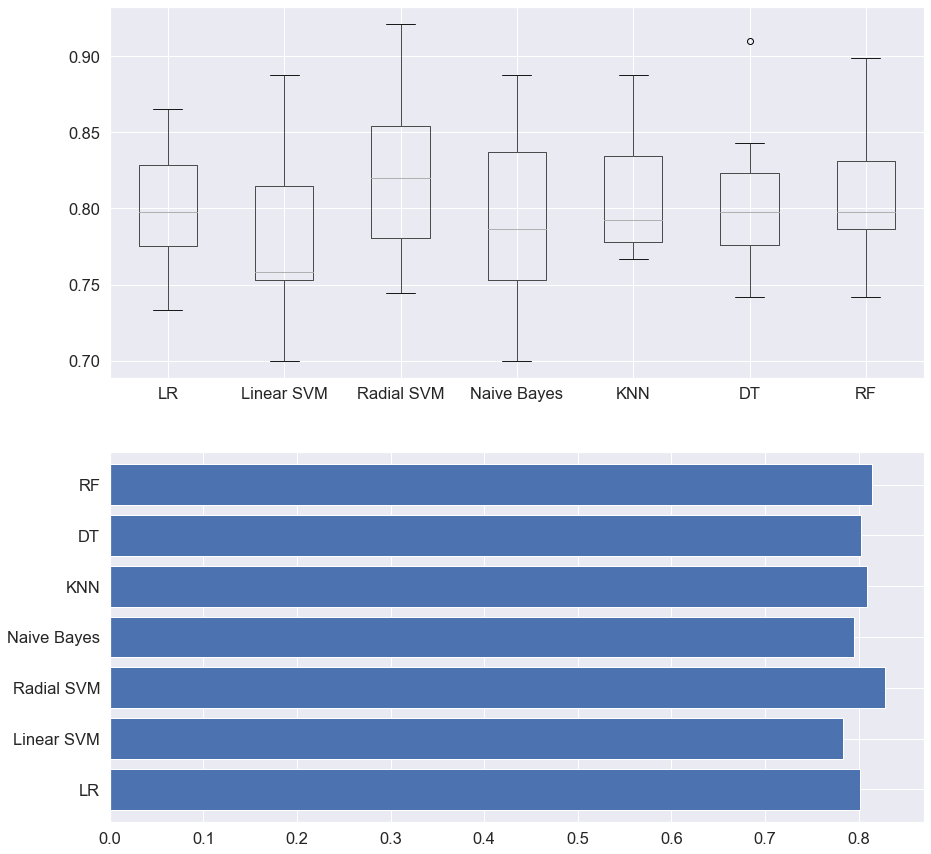

In [74]:
f, ax = plt.subplots(2, 1, figsize=(13, 15))

pd.DataFrame(accuracies, index=classifiers).T.boxplot(ax=ax[0])
cv_df.Mean.plot.barh(width=.8, ax=ax[1])

plt.show()

### Confusion Matrix

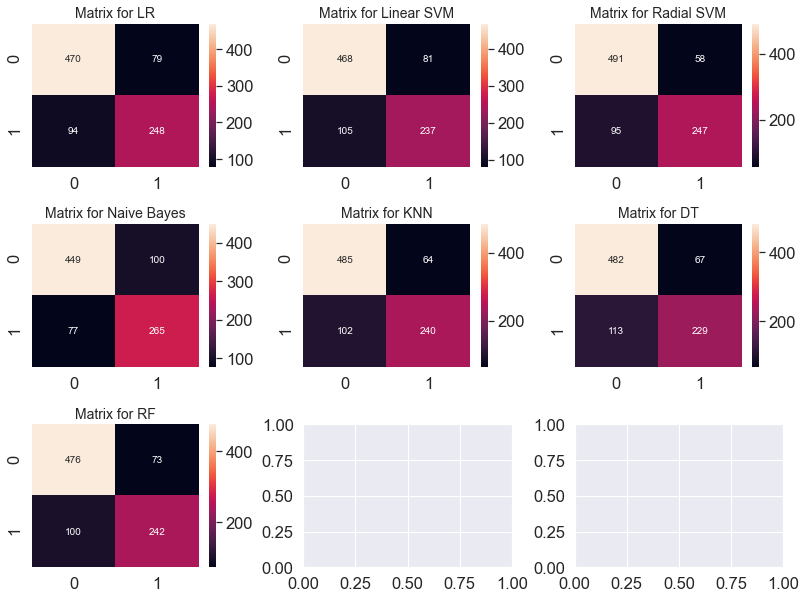

In [75]:
f, ax = plt.subplots(3, 3, figsize=(12, 10))

for i in range(len(models)):
    model, label = models[i], classifiers[i]
    pred = cross_val_predict(model, X, Y, cv=10)
    sns.heatmap(confusion_matrix(Y, pred), annot=True, fmt="2.0f", ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title("Matrix for " + label, fontsize=14)

plt.subplots_adjust(hspace=.4, wspace=.3)
plt.show()

### Hyper-Parameters Tuning (feat.GridSearchCV)

#### SVM

In [76]:
kernel = ["linear", "rbf"]
C = [.05, .1, .2, .25, .3, .4, .5, .6, .7, .8, .9, 1]
gamma = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
hyper = {"kernel": kernel, "C": C, "gamma": gamma}

model = GridSearchCV(estimator=SVC(), param_grid=hyper, verbose=True)
model.fit(X, Y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7,
                               0.8, 0.9, 1],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1],
                         'kernel': ['linear', 'rbf']},
             verbose=True)

In [77]:
print(model.best_score_, model.best_estimator_, sep="\n")

0.8282593685267716
SVC(C=0.6, gamma=0.1)


#### RF

In [78]:
hyper = {"n_estimators": range(100, 1000, 100)}
model = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=hyper, verbose=True)
model.fit(X, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': range(100, 1000, 100)}, verbose=True)

In [79]:
print(model.best_score_, model.best_estimator_, sep="\n")

0.8182160567447117
RandomForestClassifier(n_estimators=400, random_state=0)


## Ensembling

1. Voting Classifier
2. Bagging
3. Boosting

### Voting Classifier

In [80]:
ensemble_vc = VotingClassifier(estimators=[
    ("LR", LogisticRegression(C=.05)),
    ("Linear SVM", SVC(kernel="linear", probability=True)),
    ("Radial SVM", SVC(kernel="rbf", C=.5, gamma=.1, probability=True)),
    ("Naive Bayes", GaussianNB()),
    ("KNN", KNeighborsClassifier(n_neighbors=10)),
    ("DT", DecisionTreeClassifier(random_state=0)),
    ("RF", RandomForestClassifier(n_estimators=500, random_state=0))
], voting="soft").fit(train_X, train_Y)

In [81]:
print("Accuracy for ensembled model is", ensemble_vc.score(test_X, test_Y))

Accuracy for ensembled model is 0.8171641791044776


In [82]:
print("Cross validation score of ensembled model is", cross_val_score(ensemble_vc, X, Y, cv=10, scoring="accuracy").mean())

Cross validation score of ensembled model is 0.8249188514357053


### Bagging

#### Bagged KNN

In [83]:
model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3), random_state=0, n_estimators=700)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),
                  n_estimators=700, random_state=0)

In [84]:
pred = model.predict(test_X)
print("Accuracy for bagged KNN is", accuracy_score(pred, test_Y))

Accuracy for bagged KNN is 0.835820895522388


In [85]:
print("Cross validation score of bagged KNN is", cross_val_score(model, X, Y, cv=10, scoring="accuracy").mean())

Cross validation score of bagged KNN is 0.8171660424469414


#### Bagged Decision Tree

In [86]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0, n_estimators=100)
model.fit(train_X, train_Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=0)

In [87]:
pred = model.predict(test_X)
print("Accuracy for bagged DT is", accuracy_score(pred, test_Y))

Accuracy for bagged DT is 0.8171641791044776


In [88]:
print("Cross validation score of bagged DT is", cross_val_score(model, X, Y, cv=10, scoring="accuracy").mean())

Cross validation score of bagged DT is 0.8160174781523095


### Boosting

#### AdaBoost

In [89]:
adab = AdaBoostClassifier(n_estimators=200, random_state=0, learning_rate=.1)
print("Cross validation score of AdaBoost is", cross_val_score(adab, X, Y, cv=10, scoring="accuracy").mean())

Cross validation score of AdaBoost is 0.8249188514357055


#### Stochastic Gradient Boosting

In [90]:
sgb = GradientBoostingClassifier(n_estimators=500, random_state=0, learning_rate=.1)
print("Cross validation score of Gradient Boosting is", cross_val_score(sgb, X, Y, cv=10, scoring="accuracy").mean())

Cross validation score of Gradient Boosting is 0.8160174781523096


#### XGBoost

In [91]:
xgb = XGBClassifier(n_estimators=900, learning_rate=.1)
print("Cross validation score of XGBoost is", cross_val_score(xgb, X, Y, cv=10, scoring="accuracy").mean())

[22:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### Hyper parameter Tuning for AdaBoost

In [92]:
n_estimators = list(range(100, 1100, 100))
learning_rate = [.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
hyper = {"n_estimators": n_estimators, "learning_rate": learning_rate}

model = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=hyper, verbose=True)
model.fit(X, Y)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                           0.7, 0.8, 0.9, 1],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]},
             verbose=True)

In [93]:
print(model.best_score_, model.best_estimator_, sep="\n")

0.8271420500910175
AdaBoostClassifier(learning_rate=0.1, n_estimators=100)


## Confusion Matrix for the Best Model

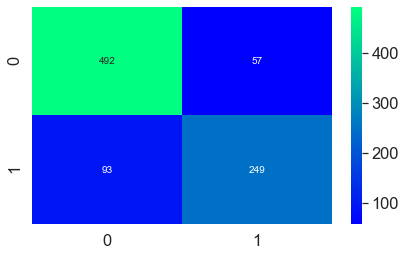

In [94]:
model = AdaBoostClassifier(n_estimators=200, random_state=0, learning_rate=.05)
pred = cross_val_predict(model, X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, pred), cmap="winter", annot=True, fmt="2.0f")
plt.show()

## Feature Importance

[22:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


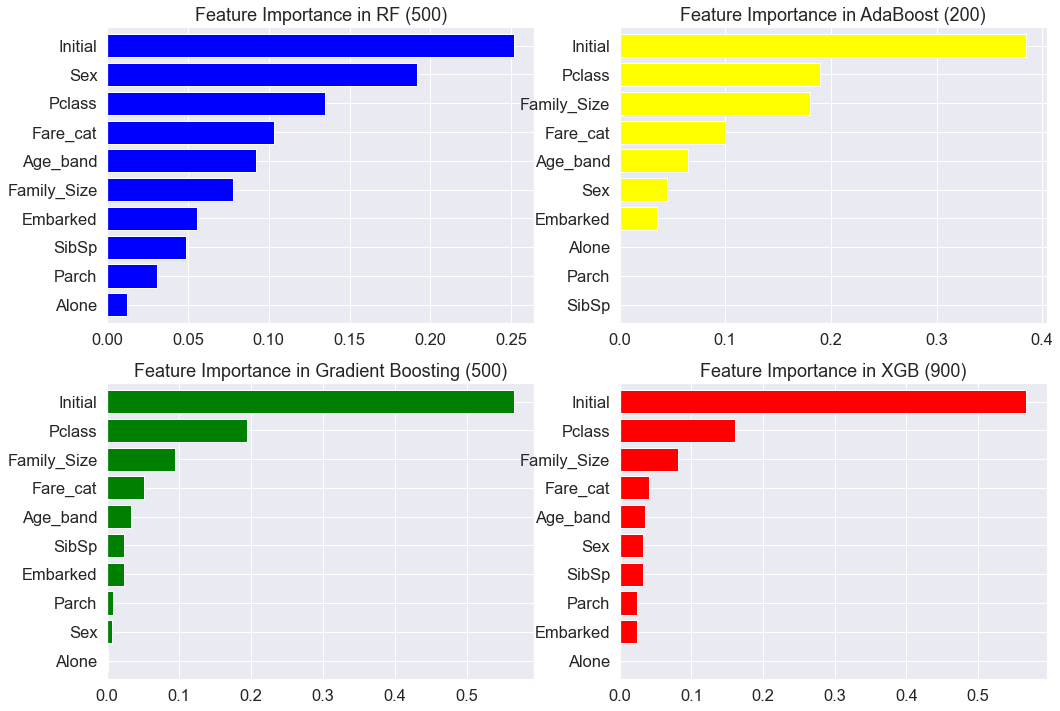

In [95]:
classifiers = [
    RandomForestClassifier(n_estimators=500, random_state=0),
    AdaBoostClassifier(n_estimators=200, learning_rate=.05, random_state=0),
    GradientBoostingClassifier(n_estimators=500, learning_rate=.1, random_state=0),
    XGBClassifier(n_estimators=900, learning_rate=.1)
]
labels = ["RF (500)", "AdaBoost (200)", "Gradient Boosting (500)", "XGB (900)"]
colors = ["blue", "yellow", "green", "red"]

f, ax = plt.subplots(2, 2, figsize=(15, 12))

for i in range(len(classifiers)):
    model, label, color = classifiers[i], labels[i], colors[i]
    model.fit(X, Y)
    pd.Series(model.feature_importances_, X.columns).sort_values(ascending=True).plot.barh(width=.8, ax=ax[i // 2, i % 2], color=color)
    ax[i // 2, i % 2].set_title("Feature Importance in " + label)

plt.show()

Boosting은 오래 걸린다. 특히 history를 활용하는 기법일수록. history를 이용한다는 건, command pattern을 이용한다는 뜻이겠지.